# Project 2: Span Identification with Sequence Labeling Models
## CS4740/5740 Fall 2020

### Project Submission Due: Oct 23rd
Please submit **pdf file** of this notebook on **Gradescope**, and **ipynb** on **CMS**. For instructions on generating pdf and ipynb files, please refer to project 1 instructions.



Names: Komukill Loganathan, Ikra Monjur

Netids: kl866, im324

Don't forget to share your newly copied notebook with your partner!


**Reminder: both of you can't work in this notebook at the same time from different computers/browser windows because of sync issues. We even suggest to close the tab with this notebook when you are not working on it so your partner doesn't get sync issues.**


### Q0: Individual Member Contribution

Briefly explain the contribution of individual group members here. Report if working loads are unfairly distributed.

We met up and worked on the project together by pair-programming.

# Overview

---

In this project, you will implement a model that identifies relevant information in a text and tags it with the appropriate label. Particularly, the task of this project is **Propaganda Identification**. The given dataset contains (manual) annotations indicating fragments of text that exhibit one of a set of well-known [propaganda techniques](https://propaganda.qcri.org/annotations/definitions.html). Your task is to develop NLP models to identify these propagandistic spans of text automatically. We will treat this as a **sequence-tagging task**: for each token in the input text, assign a label $y\in\{0,1\}$, such that *1 represents propagandistic text* and *0 represents non-propaganda*.   (A description of the original task formulation is [here](https://propaganda.qcri.org/ptc/).  We are working on a modified version of their "span identification" task.)

For this project, you will implement two sequence labeling approaches:

- Model 1 : a Hidden Markov Model (HMM)
- Model 2 : a Maximum Entropy Markov Model (MEMM), which is an adaptation of an HMM in which a Logistic Regression classifier (also known as a MaxEnt classifier) is used to obtain the lexical generation probabilities (i.e., the observation/emission probability matrix, so "observations" == "emissions" == "lexical generations").  Feature engineering is strongly suggested. (Papers from the [Workshops on Figurative Language Processing](https://sites.google.com/view/figlang2020/) can provide good insights on feature selection for this task.) You can also refer to the J&M book. 

Implementation of the Viterbi algorithm (for finding the most likely tag sequence to assign to an input text) is required for both parts, so make sure that you understand it ASAP.

You will implement and train two sequence tagging models, generate your predictions for the provided test set, and submit them to **Kaggle**. Please enter all code and answer the questions of this colab notebook.

**Jurafsky & Martin reading on HMMs and MEMMs can be found in Ch. 8.3–8.5.** The code you write can be added anywhere in the document, but we implore you to keep it readable. You will be asked to describe and motivate your models in parts of the document. You will be graded on both the code and text you write; see grading details at the end of the document.


# Notes

---

1. Please read through the entire notebook before you start coding. That might inform your code structure.
2. Grading breakdown is found at the end; please consult it.
3. Google colab does **not** provide good synchronization; we do not recommend multiple people to work on the same notebook at the same time.
4. The project is somewhat open ended. ("But that's a good thing.  Really. It's more fun that way", says Claire and Esin.) We will ask you to implement some model, but precise data structures and so on can be chosen by you. However, to integrate with Kaggle, you will need to submit Kaggle predictions using our tokenization code.  As a result, **it is probably easiest if you use our tokenization code for the entire project**.
5. You will be asked to fill in your code at various points of the document. You will also be asked to answer questions that analyze your results and motivate your implementation. These questions are named Q1-Q8. You may create additional cells to insert code, text and images as necessary.
6. Kaggle is not able to calculate *span-level* P/R/F1 measures, which is the standard way to evaluate this type of sequence-tagging task. And we don't actually care so much about the token-level tagging accuracy, which Kaggle **can** calculate.  In particular, there are many fewer propaganda tokens than non-propaganda ones, so always guessing "non-propaganda" would produce a very high accuracy.  So we are compromising by using token-level **weighted accuracy**.  Here is how it works:

A **weighted accuracy** metric that favors finding propagandistic tokens over non-propagandistic ones. The weights for both classes are the inverse of their frequencies.  

``` 
frac_propaganda = num_propaganda/num_labels   [in the answer key]
weight_propaganda = 1/frac_propaganda  
weight_non_propaganda = 1/(1-frac_propaganda)

weighted_accuracy = 
   ((weight_propaganda * # propaganda correct) 
                      +
   (weight_non_propaganda * # non_propaganda correct)) / 
   
   ((weight_propaganda * num_propaganda) 
                      +
   (weight_non_propaganda * num_non_propaganda))
```  
This is also known as the **macro average**, i.e., the average of the accuracy for each label type.


# Task and dataset

---

1. Obtain the data from Kaggle at https://www.kaggle.com/t/8a8030baefcc4d91b715f114353dba38.
2. Unzip the data. Put it into your google drive, and mount it on colab as per below:

In [9]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)



train_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS4740", "Project2", "p2-cs4740-propaganda", "train", "train") # replace based on your Google drive organization
test_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS4740", "Project2", "p2-cs4740-propaganda", "test", "test") # replace based on your Google drive organization
print(os.listdir(train_path)[:5])
print(os.listdir(test_path)[:5])

Mounted at /content/drive
['article999000565.task-si.labels', 'article788173482.task-si.labels', 'article695108099.txt', 'article716469423.txt', 'article701299732.txt']
['article698092698.txt', 'article111111121.txt', 'article111111111.txt', 'article701837665.txt', 'article701939679.txt']


3. The *train* directory contains *article{XXX}.txt* files which are plaintext documents and also *label* files such as *article{XXX}.task-si.labels*. These label files correspond to the byte-span offests of each segment of propaganda in the associated article. (The tokenizer that we describe just below converts the byte-span representation of propagandistic text spans  into the token-level gold-standard labels that your sequence-tagging models require for training.) The test directory *only* contains articles; you will use your models to detect the propagandistic spans within them.  

4. We provide a tokenizer for these documents. You **must** use this tokenizer as the labels that Kaggle expects are based upon this tokenization. The code below tokenizes each document and generates the appropriate token-level labels consistent with the associated *labels* file. (This is so that you do not need to perform any byte-level text processing.  In particular, the tokenizer  merges nested or overlapping propagandistic text spans from the article into a single segment. You really shouldn't have to look at the *lables* files at all.) The code uses python type annotations; these indicate the type of arguments the functions take.

5. Documents are represented as a list of strings, each being a token. Labels are represented as a list of integers in {0,1}, 1 corresponding to a propagandistic token and 0 to not propaganda.



In [35]:
import os
from typing import List, Tuple

from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')

def read_txt(fname):
  with open(fname) as open_article:
    lines = open_article.read()
  return lines

def read_labels(labels : str) -> List[Tuple[int, int]]:
	"processing of labels file"
	labels = labels.split("\n")[:-1]
	labels = [tuple(map(int, l.split("\t")[1:])) for l in labels]
	return labels

def sort_and_merge_labels(labels : List[Tuple[int, int]]) -> List[Tuple[int, int]]:
  "sort labels, necessary for later splitting"
  if len(labels) == 0:
    return labels
  labels = list(sorted(labels, key = lambda t: t[0]))
  # merge
  curr = labels[0]
  merged = []
  for l in labels[1:]:
      # if distinct, add
      if l[0] > curr[1]:
        merged.append(curr)
        curr = l
      # else merge
      else:
        curr = (curr[0], max(curr[1], l[1]))
  merged.append(curr)
  return merged

def split_with_labels(labels : List[Tuple[int, int]], article : str) -> Tuple[List[str], List[int]]:
  "split text into segments based upon labels"
  if len(labels) == 0:
    return [article], [0]
  segments = []
  binary_class = []
  start = 0
  for l_start, l_end in labels:
    std_seg = article[start:l_start]
    prop_seg = article[l_start:l_end]
    segments.append(std_seg)
    binary_class.append(0)
    segments.append(prop_seg)
    binary_class.append(1)
    start = l_end
  last_seg = article[start:]
  segments.append(last_seg)
  binary_class.append(0)
  return segments, binary_class

def remove_newline_fix_punc_seg(segments):
  " preprocessing necessry for tokenization to be consistent"
  segments = [s.replace("\n", " ").replace(".", " .") for s in segments]
  return segments

def remove_newline_fix_punc_art(article):
  " preprocessing necessry for tokenization to be consistent"
  article = article.replace("\n", " ").replace(".", " .")
  return article

def get_toks(input):
  output = []
  for toks in [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(input)]:
    output += toks
  return output

# This is the function you may need to call
def tokenize_article(article_file):
  "calls all functions above and perform sanity checks"
  article = read_txt(article_file)
  article = remove_newline_fix_punc_art(article)
  art_toks = get_toks(article)
  return art_toks

# This is the function you may need to call
def master_tokenizer(article_file, labels_file):
  "calls all functions above and perform sanity checks"
	# read and get labels
  article = read_txt(article_file)
  labels = read_txt(labels_file)
  labels = read_labels(labels)
  labels = sort_and_merge_labels(labels)
  segments, binary_class = split_with_labels(labels, article)
  article = remove_newline_fix_punc_art(article)
  segments = remove_newline_fix_punc_seg(segments)
  # sanity check
  reconstructed = ""
  for seg, lab in zip(segments, binary_class):
    reconstructed += seg
  assert reconstructed == article
	# tokenize
  seg_toks = []
  new_labels = []
  for seg, label in zip(segments, binary_class):
    new_toks = get_toks(seg)
    seg_toks += new_toks
    new_labels += [label for _ in range(len(new_toks))]
	# sanity check
  art_toks = get_toks(article)
  sanity = True
  if len(art_toks) != len(seg_toks):
    sanity = False
  for i, (at, st, lab) in enumerate(zip(art_toks, seg_toks, new_labels)):
    if at != st:
      sanity = False
      break
  return seg_toks, new_labels, sanity




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


 6. Execute the commands below to visualize the tokenization:

In [36]:
article_file = "article698018235.txt"
labels_file = "article698018235.task-si.labels"
article_file = os.path.join(train_path, article_file)
labels_file = os.path.join(train_path, labels_file)
tokens, labels, _ = master_tokenizer(article_file, labels_file)

print(len(tokens), len(labels), tokens[:10], labels[:20])

700 700 ['dan', 'fishback', ':', 'it', "'s", 'okay', 'to', 'boycott', 'israeli', 'plays'] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


7.  Provide some quantitative data exploration. Assess dataset size, documents lengths and class inbalance. Give some examples of sentences containing propaganda techniques.

In [37]:
# code here
train = os.listdir(train_path)
train.sort()

# number of files: 
len(train)

# function to make paths and use master_tokenizer to tokenize article and label
def make_tokens(article, label):
  article_file = os.path.join(train_path, article)
  label_file = os.path.join(train_path, label)
  return master_tokenizer(article_file, label_file)

# article from cell above
print(tokens[47:70])
print(labels[47:70])

## article 5 - short text
tokens5, labels5, _ = make_tokens(train[5],train[4])
print(len(tokens5))
print(labels5.count(1))
print(labels5.count(0))

## article 7 - long
tokens7, labels7, _ = make_tokens(train[7],train[6])
print(len(tokens7))
print(labels7.count(1))

['the', 'american', 'jewish', 'historical', 'society', 'was', 'caught', 'collaborating', 'with', 'jvp', ';', 'a', 'radical', 'anti-israel', 'hate', 'group', 'with', 'links', 'to', 'anti-semitism', '.', 'here', "'s"]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
192
13
179
1388
121


### Q1: Initial data observations
What are your initial observations of the dataset after you explore the dataset?

**Answer:** We see more non-propagandistic words than propagandistic words across the training dataset. We found 520 files in the train dataset, 260 of them are articles and 260 of the rest are label files.

# Model 1: HMM Implementation

---

In this section, you will implement a HMM model for this task. We expect:


1. An implementation of the **Viterbi algorithm** that can be used to infer token-level labels --- propaganda or not propaganda --- for an input document.   This process is commonly referred to as **decoding**.
2. Code for counting and smoothing of labels and words as necessary to support the HMM decoding. (This is pretty much what you already know how to do from project 1.)


The tokenization of documents can be performed with the code we provide above. We suggest you calculate probabilities in a log form.  Bigram Viterbi is O(sm^2) where s is the length of the sentence and m is the number of tags. Your implementation should have similar efficiency.

Code of Academic Integrity:  We encourage collaboration regarding ideas, etc. However, please **do not copy code from online or share code with other students**. We will be running programmes to detect plagiarism.

In [39]:
# Your implementation here
# we expect a function or class, mapping a sequence of tokens to a sequence of labels
# this function or class will be called below

'''
tokenize_train tokenizes the given dataset
[train]: dataset
[unknown_handling]: boolean to indicate whether unknown words should be handled
Returns the list of tokens, the corresponding labels, and the vocabulary set
'''
def tokenize_train(train, unknown_handling=True):
  tokens = []
  labels = []
  word_set = set()

  for i in range(0, len(train), 2):
    token, label, _ = make_tokens(train[i+1], train[i])
    processed_tokens = []
    for tok in token:
      if tok not in word_set and unknown_handling:
        word_set.add(tok)
        tok = "<UNK>"
      processed_tokens.append(tok)
    tokens.append(processed_tokens)
    labels.append(label) 
    
  return tokens, labels, word_set

In [40]:
from collections import Counter

'''
hmm_model creates the start, transition, and emission probability matrices for the hmm model
  using add-k smoothing for the emission probabilities
[tokens]: tokenized list of articles
[labels]: labels for the tokens in the articles
[word_set]: vocabulary set
[k]: parameter for add-k smoothing
Returns the probability matrices
'''
def hmm_model(tokens, labels, word_set, k):
  ## start matrix P(t_1)
  ## transition prob matrix P(t_i | t_i-1)
  ## emission prob matrix P(w_i | t_i)
  start_probs = Counter()
  trans_probs = Counter()
  labels_freq = Counter()
  emiss_probs = Counter()

  for j in range(0, len(labels)):
    l = labels[j]
    t = tokens[j]
    start_probs[l[0]]+=1
    labels_freq[l[0]]+=1
    emiss_probs[(l[0], t[0])] += 1
    for i in range(1, len(l)):
      trans_probs[(l[i-1], l[i])] += 1
      labels_freq[l[i]]+=1
      emiss_probs[(l[i], t[i])] += 1

  start_probs = {key: v / len(labels) for key,v in start_probs.items()}
  trans_probs = {key: v / labels_freq[key[0]] for key,v in trans_probs.items()}

  # add-k smoothing for emission probabilities
  V = len(word_set)
  emiss_probs = {key: (v + k) / (labels_freq[key[0]] + k*V) for key,v in emiss_probs.items()}

  return start_probs, trans_probs, emiss_probs

In [41]:
import numpy as np
import math

'''
calc_max calculates the maximum probabaility and the corresponding previous state given the observation
[viter_mat]: viterbi matrix
[t]: index of the current token
[s]: current state for which we are calculating the probability for
[obs_t]: the current token
Returns the maximum probabaility and the corresponding previous state
'''
def calc_max(viter_mat, t, s, obs_t):
  max = float('-inf')
  argmax =-1
  for s_prime in start_probs:
    num = viter_mat[s_prime, t-1] + math.log(trans_probs[(s_prime, s)]) + math.log(emiss_probs[s, obs_t])
    if num > max:
      max = num
      argmax = s_prime
  return max, argmax

##viterbi algo
'''
viterbi calculate the optimal path (implementation of the viterbi algorithm)
[observation]: list of tokenized words
Returns the best path and its probability
'''
def viterbi(observation):
  viter_matrix = np.zeros((len(start_probs), len(observation)))
  back_pointers = np.zeros((len(start_probs), len(observation)), dtype=int)
  # number of states = 2 
  for s in start_probs:
    if (s, observation[0]) not in emiss_probs :
      obs = '<UNK>'
    else:
      obs = observation[0]
    viter_matrix[s, 0] = math.log(start_probs[s]) + math.log(emiss_probs[(s, obs)])
    back_pointers[s, 0] = 0
  for t in range(1, len(observation)):
    for s in start_probs:
      if (s, observation[t]) not in emiss_probs:
        obs = '<UNK>'
      else:
        obs = observation[t]
      viter_matrix[s, t], back_pointers[s, t] = calc_max(viter_matrix, t, s, obs)

  bestpathprob = np.amax(viter_matrix[:,len(observation)-1])
  bestpathpointer = np.argmax(viter_matrix[:,len(observation)-1])
  bestpath = [bestpathpointer]

  counter = len(observation)-1
  while counter != 0:
    bestpath.append(back_pointers[(bestpath[-1],counter)])
    counter-=1
  bestpath.reverse()

  return bestpath, bestpathprob

## Validation Step

1. Create a validation set from the given dataset, i.e. a subset of (~10%) the training dataset that you only use for evaluating the models, not for training.  (You can think of the validation set as a sample test set.)
2. Train your HMM model on the (remainder of the) training set and evaluate it on the validation set. Report **weighted accuracy**, which is explained in the *Notes* section above.

Please also take a look into your misclassified cases, as we will be performing error analysis in the *Evaluation* section. We expect smoothing, unknown word handling and correct emission (i.e., lexical generaion) probabilities. 

In the *Kaggle Submission* section, there is code provided for generating the output file in the form required for Kaggle.  If you find it useful for computing weighted accuracy, you can use it here as well.

In [42]:
'''
run_viterbi runs the viterbi algorithm for all the articles in the given dataset
[data]: list of articles
Returns predictions from the viterbi and the true labels
'''
def run_viterbi(data):
  data_tokens, data_labels, data_word_set = tokenize_train(data, unknown_handling=False)
  viterbi_result = []
  for i in range(len(data_tokens)):
    article = data_tokens[i]
    path, path_prob = viterbi(article)
    viterbi_result.append((path, path_prob))
  return viterbi_result, data_labels

In [43]:
# Evaluate/validate your model here
# you may attach pictures of graphs etc.

## validation set
ninety_percent = int(len(train)*0.9)
training_set = train[:ninety_percent]
validation_set = train[ninety_percent:]
print(len(validation_set))

## make HMM model & train
tokens, labels, word_set = tokenize_train(training_set)
start_probs, trans_probs, emiss_probs = hmm_model(tokens, labels, word_set, 0.001)

## run model on validation set
viterbi_result_hmm, actual_labels = run_viterbi(validation_set)

52


In [44]:
## error analysis on HMM
valid_tokens, _, _ = tokenize_train(validation_set, unknown_handling=False)

for j in range(1):
  tokens_labeled = []
  print("Article", j)
  print("predictions:", viterbi_result_hmm[j][0])
  print("actual:     ", actual_labels[j]) 
  for i in range(len(valid_tokens[j])):
    token = valid_tokens[j][i]
    pred_label = viterbi_result_hmm[j][0][i]
    actual_label = actual_labels[j][i]
    tokens_labeled.append((token, pred_label, actual_label))
  print(tokens_labeled)

Article 0
predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [56]:
## evaluate validation set
'''
evaluate the predictions from the hmm model using weighted accuracy
[viterbi_res]: predictions from the viterbi algorithm using hmm model
[actual_labels]: the actual labels of the tokens
Returns the weighted_accuracy
'''
def evaluate(viterbi_res, actual_labels):
  num_propaganda = 0
  num_labels = 0
  for labels in actual_labels:
    num_propaganda += labels.count(1)
    num_labels += len(labels)

  frac_propaganda = num_propaganda / num_labels
  weight_propaganda = 1 / frac_propaganda
  weight_nonpropaganda = 1 / (1-frac_propaganda)
  
  propaganda_correct = 0
  non_propaganda_correct = 0
  num_non_propaganda = num_labels - num_propaganda

  for i in range(len(viterbi_res)):
    for j in range(len(viterbi_res[i][0])):
      if actual_labels[i][j] == viterbi_res[i][0][j]:
        if viterbi_res[i][0][j] == 1:
          propaganda_correct += 1
        else:
          non_propaganda_correct += 1
  # print("False positives: ", num_non_propaganda - non_propaganda_correct)
  # print("False negatives: ", num_propaganda - propaganda_correct)
  weighted_accuracy = ((weight_propaganda * propaganda_correct) + (weight_nonpropaganda * non_propaganda_correct)) / ((weight_propaganda * num_propaganda) + (weight_nonpropaganda * num_non_propaganda))
  return weighted_accuracy

In [46]:
evaluate(viterbi_result_hmm, actual_labels)

False positives:  12304
False negatives:  416


0.5181856637763844



### Q2 : Explan your HMM implementations

Q2.1: Explain here how you implemented HMMs (e.g. **which algorithms/data structures** you used). Make clear which parts were implemented from scratch vs. obtained via an existing package. 

**Answer:** We created our HMM model, i.e. our start probability matrix, transmission probability matrix, and emission probability matrix, using Counters data structure. We created a helper function that uses master_tokenize() to loop through all articles in the dataset and make tokens and labels lists. We handled unknown words by replacing the first occurrence of each word to be \<UNK> token. We created a word types set to store the first occurrences of each word, i.e. the vocabulary set. We used the tokens list created to manually count the word and label frequencies to create the probability matrices. And then, we did add-k smoothing for emission probabilities. 

We created a viterbi function to get the optimal path and probability of given sequence of words, i.e. articles. We followed the viterbi algorithm pseudocode on J&M 8.4.5 and added unknown word handling. We also created a helper function to calculate the maximum likelihood of the current observation sequence at each time step. We stored the viterbi paths, backpointers to the path and the probabilities in a numpy array. All probabilities are calculated and stored in log base. 

Q2.2: Explain and motivate any design choices providing the intuition behind them (e.g. which methods you used for your HMM implementation, why?).

**Answer:** We used add-k smoothing for the emission probability matrix to ensure that less seen words in the dataset can be taken into account with a better probability mass. We also did unknown-word handling to ensure unseen words in validation set and, later on, in the test set are accounted for by our model by providing them with a larger probability mass than zero. We did unknown word handling when we trained our hmm model as well as in our viterbi when we are predicting. We used Viterbi for decoding the HMM as provided in the problem statement.



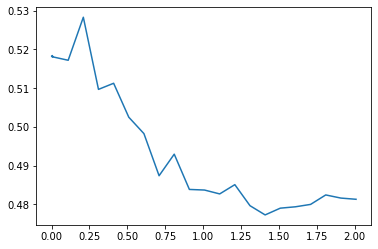

In [57]:
## ploting the weighted accuracies for different k values
k_vals = []
acc_vals = []
for k in np.arange(0.001, 0.01, 0.001):
  k_vals.append(k)
  start_probs, trans_probs, emiss_probs = hmm_model(tokens, labels, word_set, k)
  viterbi_result, actual_labels = run_viterbi(validation_set)
  acc_vals.append(evaluate(viterbi_result, actual_labels))
for k in np.arange(0.01, 2.1, 0.1):
  k_vals.append(k)
  start_probs, trans_probs, emiss_probs = hmm_model(tokens, labels, word_set, k)
  viterbi_result, actual_labels = run_viterbi(validation_set)
  acc_vals.append(evaluate(viterbi_result, actual_labels))

import matplotlib.pyplot as plt
plt.plot(k_vals, acc_vals)

### Q3: Results Analysis

Q3.1: Explain here how you evaluated the models. Summarize the performance of your system and any variations that you experimented with on the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:** We used 10% of the given dataset as the validation set to test the accuracy of our model. We trained our HMM model and then ran the viterbi algorithm on the validation set for the HMM model we created. We tried different k values for our add-k smoothing and noticed that a smaller value of k results in a higher accuracy. We measured accuracy by using the weighted accuracy formula provided above. The plot above is a plot with different k values in the x-axis vs their corresponding weighted accuracy in the y-axis. The trend shows that lower k-values produces a higher accuracy. We also see that the accuracy peaks when k is around 0.2 but the test accuracy (on kaggle) is much lower when k = 0.2. Thus, we chose our k to be 0.001 which gives us a much better accuracy on our test and slightly lower on our validation. When we lower our k value, we noticed that the accuracy did not change much.


Q3.2: When did the system work well? When did it fail?  Any ideas as to why? How might you improve the system?

**Answer:** The system failed when there was no smoothing and unknown words handling done for the model. This is because when there were unknown words in the validation dataset, the probability would simply be 0 which would render the model useless. After adding the smoothing and unknown words handling, the system worked well. We used add-k smoothing, as previously mentioned, and experimented with different k values. We started with k = 1 and then decreased the k value and noticed an imporovement in the accuracy. This is because a smaller k does not affect the overall probability as much and therefore, preserves the accuracy of the model. 

Q3.3: What is the effect of unknown word handling and smoothing?

**Answer:** Adding unknown word handling and smoothing improves the model by accounting for unseen word in validation/test set. It ensures that the probabilities calulcated are always non-zero which would otherwise render the model useless.



# Model 2: MEMM Implementation

---


In this section, you will implement a Maximum Entropy Markov Model (**MEMM**) to perform the same propaganda detection task. Your model should consist of a MaxEnt classifier with Viterbi decoding. 
 
1. We have already performed tokenizations for documents. You can either use a MaxEnt classifier from an existing package or write the MaxEnt code yourself. **Important note:  MaxEnt classifiers are statistically equivalent to multi-class logistic regression, so you can use packages for multi-class LR instead of MaxEnt.**

2. Use the classifier to learn a probability $P(t_i|features)$. You may replace either the lexical generation probability – $P(w_i|t_i)$ – or the transition probability – $P(t_i|t_{i−1})$ – in the HMM with it, or you may replace the entire *lexical generation probability * transition probability*  calculation – $P (w_i|t_i) ∗ P (t_i|t_{i−1)} – $ in the HMM with it. 

3. To train such classifier, you need to pick some feature set. The content of the feature set is up to your choice. You should be trying different feature sets, and evaluate your choices on the validation set. Pick the feature set that performs overall the best according to the F1 measure.

4. Use your own implementation of the **Viterbi algorithm**, which you can modify from the one you developed for the HMM model. You will need the probabilities that you obtain from the MaxEnt classifier. 

5. Remember to use same training and validation split when evaluating the MEMM to have a **fair comparison** with your **HMM model**.


Please also take a look into your misclassified cases, as we will be performing error analysis in *Evaluation* section. 




---
Work flow summary:

![alt text](https://drive.google.com/uc?export=view&id=14VfjW3yDyXLojWM_u0LeJYdDOSLkElBn)


In [48]:
# Your model implementation here
# we expect a function of class, mapping a sequence of tokens to a sequence of labels
# this function or class will be called below
#
# You will need:
# 1. Extract Features
# 2. Train MaxEnt
# 3. To call Viterbi 

## 1. Extract Features
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()

"""
extract_features extracts features of the training data set
[tokens]: list of tokenized articles
[labels]: list of article labels
[include_labels]: indicator of whether to include labels in the extracted features
Returns a list of feature dictionaries for each word in the list of articles
"""
def extract_features(tokens, labels = None, include_labels = True):
  # features - word, lemmatized word, prev_tag, next_tag, prev_word and next_word (original and lemmatized)
  features_lst = []
  for j in range(len(tokens)):
    article = tokens[j]
    if include_labels:
      label = labels[j]
    for i in range(len(article)):
      word_dict = {}
      word_dict["word"] = article[i]
      word_dict["lemma"] = lemma.lemmatize(article[i])
      if include_labels:
        word_dict["prev_tag"] = None if i == 0 else label[i-1]
        word_dict["next_tag"] = None if i == len(article)-1 else label[i+1]
      word_dict["prev_word"] = None if i == 0 else article[i-1]
      word_dict["prev_word_lemma"] = None if i == 0 else lemma.lemmatize(article[i-1])
      word_dict["next_word"] = None if i == len(article)-1 else article[i+1]
      word_dict["next_word_lemma"] = None if i == len(article)-1 else lemma.lemmatize(article[i+1])
      if include_labels:
        features_lst.append((word_dict, label[i]))
      else:
        features_lst.append(word_dict)
  return features_lst

# tokenize training data and extract features
tokensMEMM, labelsMEMM, _ = tokenize_train(training_set, unknown_handling = False)
train_features = extract_features(tokensMEMM, labels=labelsMEMM)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [49]:
## 2. Train MaxEnt
from nltk.classify import maxent

classifier = maxent.MaxentClassifier.train(train_features, max_iter = 10)

  ==> Training (10 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.098
             2          -0.12948        0.905
             3          -0.09486        0.954
             4          -0.07184        0.979
             5          -0.05758        0.984
             6          -0.04828        0.986
             7          -0.04187        0.987
             8          -0.03722        0.988
             9          -0.03370        0.989
         Final          -0.03095        0.990


In [50]:
## 3. To call Viterbi 

"""
calc_max_MEMM calculates the maximum probabaility and the corresponding previous state given the observation
[viter_mat]: viterbi matrix
[t]: index of the current token
[s]: current state for which we are calculating the probability for
[obs_t]: the current token
[obs]: the current token after handling unknown word
[num_states]: number of states, i.e. labels
[prev_obs]: previous token 
Returns the maximum probabaility and the corresponding previous state
"""
def calc_max_MEMM(viter_mat, t, s, obs_t, obs, num_states, prev_obs):
  max = float('-inf')
  argmax = -1
  for s_prime in range(num_states):
    obs_feature_dict = {\
                        "word": obs_t, \
                        "prev_tag": s_prime, \
                        "lemma": lemma.lemmatize(obs_t), \
                        "prev_word": prev_obs, \
                        "prev_word_lemma": lemma.lemmatize(prev_obs), \
                        }
    num = viter_mat[s_prime, t-1] + math.log(emiss_probs[(s, obs)]) + math.log(classifier.prob_classify(obs_feature_dict).prob(s))
    if num > max:
      max = num
      argmax = s_prime
  return max, argmax

"""
viterbi_MEMM calculates the optimal path (implementation of the viterbi algorithm)
[observation]: list of tokenized words
[classifier]: trained maxent classifer
[num_states]: number of states/labels
Returns the best path and its probability
"""
def viterbi_MEMM(observation, classifier=classifier, num_states=2):
  #number of states = 2 
  viter_matrix = np.zeros((num_states, len(observation)))
  back_pointers = np.zeros((num_states, len(observation)), dtype=int)
  for s in range(num_states):
    if (s, observation[0]) not in emiss_probs:
        obs = '<UNK>'
    else:
        obs = observation[0]
    obs_feature_dict = { \
                        "word": observation[0], \
                        "lemma": lemma.lemmatize(observation[0]), \
                        "prev_tag":None, \
                        "prev_word": None, \
                        "prev_word_lemma": None, \
                        }
    viter_matrix[s, 0] = math.log(emiss_probs[(s, obs)]) + math.log(classifier.prob_classify(obs_feature_dict).prob(s))
    back_pointers[s, 0] = 0
  for t in range(1, len(observation)):
    for s in range(num_states):
      if (s, observation[t]) not in emiss_probs:
        obs = '<UNK>'
      else:
        obs = observation[t]
      viter_matrix[s, t], back_pointers[s, t] = calc_max_MEMM( \
                                                              viter_matrix, t, s, observation[t], obs, num_states, \
                                                              observation[t-1])

  bestpathprob = np.amax(viter_matrix[:,len(observation)-1])
  bestpathpointer = np.argmax(viter_matrix[:,len(observation)-1])
  bestpath = [bestpathpointer]

  counter = len(observation)-1
  while counter > 0:
    bestpath.append(back_pointers[bestpath[-1],counter])
    counter-=1
  bestpath.reverse()

  return bestpath, bestpathprob

In [51]:
"""
evaluate_MEMM the predictions from MEMM using weighted accuracy
[viterbi_res]: predictions from viterbi_MEMM using memm
[actual_labels]: the actual labels of the tokens
Returns the weighted_accuracy
"""
def evaluate_MEMM(viterbi_res, actual_labels):
  num_propaganda = actual_labels.count(1)
  num_labels = len(actual_labels)

  frac_propaganda = num_propaganda / num_labels
  weight_propaganda = 1 / frac_propaganda
  weight_nonpropaganda = 1 / (1-frac_propaganda)
  
  propaganda_correct = 0
  non_propaganda_correct = 0
  num_non_propaganda = num_labels - num_propaganda

  for i in range(len(viterbi_res)):
      if actual_labels[i] == viterbi_res[i]:
        if viterbi_res[i] == 1:
          propaganda_correct += 1
        else:
          non_propaganda_correct += 1
  print("False positives: ", num_non_propaganda - non_propaganda_correct)
  print("False negatives: ", num_propaganda - propaganda_correct)
  weighted_accuracy = ((weight_propaganda * propaganda_correct) + (weight_nonpropaganda * non_propaganda_correct)) / ((weight_propaganda * num_propaganda) + (weight_nonpropaganda * num_non_propaganda))
  return weighted_accuracy

In [52]:
# Run your model on validation set
# You will need to 
# 1. Call your function above to get a prediction result on Validation Set
# 2. Report Metrics
# (See if you need to modify your feature set)
import itertools

# tokenize validation set
valid_tokens, valid_labels, _ = tokenize_train(validation_set, unknown_handling=False)

# run viterbi_memm on validation set and make one contiguous list of predictions
valid_path = []
viterbi_result_memm = []
for article in valid_tokens:
  valid_best_path, _ = viterbi_MEMM(article)
  viterbi_result_memm.append(valid_best_path)
  valid_path += valid_best_path

# flattening valid_labels list
valid_labels_flat = list(itertools.chain(*valid_labels))

# evaluate predictions for validation set 
evaluate_MEMM(valid_path, valid_labels_flat)

False positives:  3377
False negatives:  2920


0.48580699685652196

In [58]:
## error analysis on MEMM

for j in range(1):
  tokens_labeled = []
  print("Article ", j)
  print("Predictions:   ", viterbi_result_memm[j])
  print("Actual labels: ", valid_labels[j]) 
  for i in range(len(valid_tokens[j])):
    token = valid_tokens[j][i]
    pred_label = viterbi_result_memm[j][i]
    actual_label = valid_labels[j][i]
    tokens_labeled.append((token, pred_label, actual_label))
  print(tokens_labeled)

Article  0
Predictions:    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 

### Q4: Implementation Details

Q4.1: Explain here how you implemented the MEMM (e.g. which algorithms/data structures you used, what features are included). Make clear which parts were implemented from scratch vs. obtained via an existing package. 


**Answer:** We first created a list of feature dictionaries which includes the word, previous word, and next word, both original and lemmatized. We also included the previous tag, and the next tag as our features. In order to lemmatize the words, we used the nltk WordNetLemmatizer package. Then, we used our features list to train the MEMM using the nltk maximum entropy (maxent) package with a maximum iteration of 10. After getting our maximum entropy classifier, we implemented viterbi algorithm for MEMM. The implementation is similar to the HMM viterbi but to get the probabilities to calculate all path probabilities, we used our MEMM classifier multiplied by the emission probability calculated at when we created a HMM. We included emission probabilities along with maxent probabilities because without emission probabilities the maxent classifier and MEMM would always output the predictions to be 0, i.e. non-propagandistic because there are way more non-propagandistic words than not in the train dataset. Hence, the classifier is too biased towards non-propagandistic words. 

Q4.2: What features are considered most important by your MaxEnt Classifier? Why do you think these features make sense? Describe your experiments with feature sets.

**Answer:** We found that the previous tags and the next tags are the most important features for our MaxEnt Classifier. We realized that adding these features to our features list increased the accuracy of our predictions. It makes sense for these features to be the most important because when we analyzed our dataset, we noticed that multiple propagandistic words usually occur together in between nonpropagandistic words. Thus, looking at the previous and next tags should help determine the tag of the current word (i.e if the word is between two propagandistic words, it is likely that that word is also propagandistic). We performed ablation study in order to validate which features are the most important. We tried features like part-of-speech tags and sentiment tags in addition to the features we are currently using.



### Q5: Results Analysis

Q5.1: Explain here how you evaluated the MEMM model. Summarize the performance of your system and any variations that you experimented with the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:** In order to evaluate our MEMM, we first trained on 90% of the given dataset and used the remaining 10% as our validation set. We used weighted accuracy shown above to evaluate our MEMM model on the validation set. In addition, we also tried different features list for training our model and then evaluated it on the validation set as well as test set submitted on Kaggle. The table below shows some of the feature combinations we tried and their respective accuracy on our validation set as well as test set (accuracy from Kaggle):

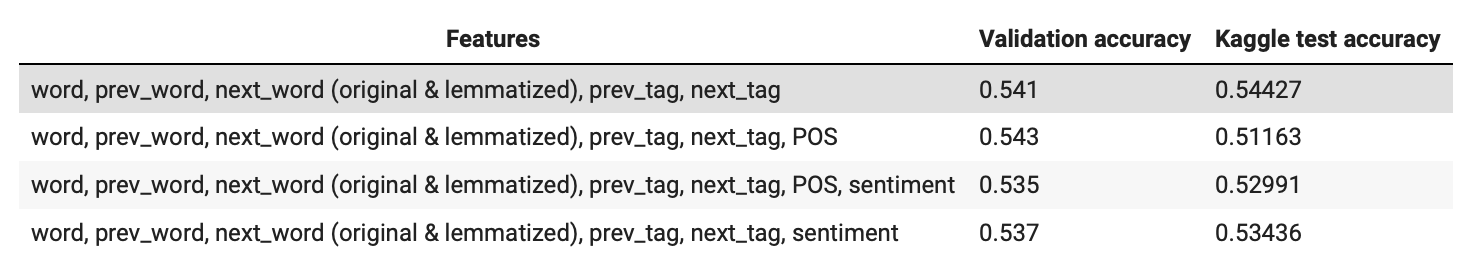

In [54]:
path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "p2_table.png")
Image(filename=path)



As shown in the table, features: \{word, prev_word, next_word (original & lemmatized), prev_tag, next_tag} give us the highest accuracy on our test set on Kaggle and a good validation accuracy as well. Hence, we use this set of features for our final MEMM.
We also experimented by changing the max_iter parameter of our MaxEnt Classifeir that we use to get the probabilities to find an appropriate training accuracy to avoid overfitting. 

Q5.2: An analysis on feature selection for the MEMM is required – e.g. what features **help most**, why? An **error analysis** is required – e.g. what sorts of errors occurred, why? 

**Answer:** The features that help most are the previous and next tags because when we analyzed our dataset, we noticed that multiple propagandistic words usually occur together in between nonpropagandistic words. Thus, looking at the previous and next tags help determine the tag of the current word (i.e if the word is between two propagandistic words, it is likely that that word is also propagandistic). We had also included the part-of-speech (pos) and sentiment of the word as part of our features because propagandistic words are most likely to be only of certain pos (i.e conjunctions are less likely to be propagandistic compared to adjectives). However, when we performed ablation study by removing pos tags and sentiment, the accuracy of the model increased. So, we realized that pos tags and sentiment did not matter as we initially thought and removed them from our feautres list. When we analyzed a few articles from our validation set, we noticed that many of the words were falsely being labeled as propaganda. There were 6923 false positives and 1614 false negaitves which makes sense after directly comparing the predictions and actual labels of a few articles from the validation set, more false positives were noticed. Also, there were clusters of progandistic words which makes sense but the clusters are much larger than what we had noticed in our training dataset. This is because the previous tag plays a large role when predicting the label so if the previous tag was 1, it is likely that the currect tag will also be 1 and this logic creates a larger cluster of 1 than the actual labels. The transitions from 0 to 1 and 1 to 0 usually have lower probabilities compare to transitions from 0 to 0 and 1 to 1.

Q5.3: When did the system work well, when did it fail and any ideas as to why? How might you improve the system?

**Answer:** The system worked well when we included the features list of current word, previous word, next word (original and lemmatized), previous tag, and next tag. The system failed when only maxent classifier probability was used in our MEMM viterbi calculation. This was because the system was too biased towards non-propagandistic words as there are way more of those than propagandistic words in the train dataset. Because of the severe class imbalance, our MEMM and viterbi would always predict all words to be non-propagandistic. To solve this issue, we used the emission probability calculated for our HMM multiplied by maxent classifier probability to boost the probability of a word being propagandistic. This improved the system and we had non-zero count of propandistic word prediction.

The system improved when we included lemmatized words and the next tags (initially we only had original words and previous tags). Including the next tag improved the model because the label of the current word depends on the labels of the surrounding words. Hence, including both the previous and the next tags gives a better picture of this relationship to the model. Lemmatizing improved the model because only the root word should matter when determining if the word is propagandistic or not (i.e the propagandistic label of the words hate and hates should not vary just because of the suffix). We also noticed that increasing the maximum iteration of the MaxEnt classifier also improved our model. We initially used 5 iterations and then changing it to 10 improved the accuracy. We did not increase it more since we don't want overfitting of the model. 



In [59]:
## ERROR ANALYSIS

# HMM
# False positives:  12304
# False negatives:  416

# MEMM
# False positives:  6923
# False negatives:  1614

for j in range(1):
  tokens_labeled = []
  print("Article", j)
  print("hmm   ", viterbi_result_hmm[j][0])
  print("memm  ", viterbi_result_memm[j])
  print("labels", valid_labels[j]) 
  for i in range(len(valid_tokens[j])):
    token = valid_tokens[j][i]
    pred_hmm = viterbi_result_hmm[j][0][i]
    pred_memm = viterbi_result_memm[j][i]
    actual_label = valid_labels[j][i]
    tokens_labeled.append((token, pred_hmm, pred_memm, actual_label))
  print(tokens_labeled)

Article 0
hmm    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1


#Comparing HMMs and MEMMs

---


### Q6:


Compare here your results for your HMM and the MEMM. Which of them performs better? 

**Answer:** According to our weighted accuracies, MEMM performed better because MEMM takes more features into account while HMM only looks at the previous tag to determine the path probailities and the best path for the word sequence. MEMM also can take into account long-distance features while HMM cannot. This is how we were able to include the next word and the next tag as part of our features list for MEMM which improved the model.


###Q7: Error Analysis
Q7.1: Do some error analysis. What are error patterns you observed that the HMM makes but the MEMM does not? Try to justify why/why not?

**Answer:** In the HMM, the false positives is much higher. The HMM has false positives of 12304 while the MEMM has false positives of 6923. The HMM false positives is almost double the false positves of MEMM. We also noticed this when we analyzed the first few articles in our validation set. The cluster of propagandistic words was much larger for the HMM predictions compared to the MEMM predictions. Another error pattern we noticed in the HMM is that many of the time punctuations are characterized as propagandistic if their previous token was labeled as propaganda while in MEMM that is not the case. In this example, ('sentence', HMM: 1, MEMM: 1), (':', HMM: 1, MEMM: 0), ('``', HMM: 1, MEMM: 0), we can see that even when both HMM and MEMM predict the word "sentence" to be propagandistic, the MEMM does not predict the punctuation to be propagandistic which is correct. Both of these errors most likely occur because in our HMM, the tag of the word is heavily dependent on the previous tag only while when we train our MEMM model, we are taking both the previous and the next tags and words as part of our features list. 

Q7.2: What are error patterns you observed that MEMM makes but the HMM does not? Try to justify what you observe?

**Answer:** The MEMM predicts more false negatives than the HMM, specifically the MEMM has a false negative of 1614 while the HMM has a false negaitve of 416. For example, 
the words in the phrase "the evil doings of israel" from the validation set all have an actual label of propaganda. However, MEMM labels them as nonpropagandistic while HMM labels them as propagandistic. The reason that MEMM has more false negative than HMM is simply because HMM leans more towards labeling the words 1s as opposed to 0s which creates lower false negatives (but much higher false positives as discussed above). 




# Kaggle Submission 
---

Using the best-performing system from among all of your HMM and MEMM models, generate predictions for the test set, and submit them to Kaggle at https://www.kaggle.com/t/8a8030baefcc4d91b715f114353dba38. Note, you **need** to use our tokenizer as the labels on Kaggle corresponds to these. Below, we provide a script that submits a random guess/all ones or all zeroes in the correct format. Note that you only need to provide a function which takes as input a sequence of tokens, and outputs a sequence of labels (in the form of integers  in {0,1}, 1 corresponding to propaganda). As a scoring metric on Kaggle, we use **weighted accuracy**, described in the *Notes* section towards the beginning of the notebook.


In [ ]:
import random
from typing import Callable


def submission_to_csv(binary_class : List[List[int]], fname : str):
  # writes submission to CSV
  new_binary = []
  for classes in binary_class:
    new_binary += classes
  with open(fname, 'w') as file:
    file.write('id,category\n')
    for i, line in enumerate(new_binary):
      file.write('{},{}\n'.format(i,line))


def random_predictor(article_tokens : List[str]) -> List[int]:
  # random predictor
  output = []
  for _ in range(len(article_tokens)):
    output.append(random.randint(0,1))
  return output

def always_one(article_tokens : List[str]) -> List[int]:
  # random predictor
  output = []
  for _ in range(len(article_tokens)):
    output.append(1)
  return output

def always_zero(article_tokens : List[str]) -> List[int]:
  # random predictor
  output = []
  for _ in range(len(article_tokens)):
    output.append(0)
  return output


def generate_submission(predictor: Callable[[List[str]], List[int]], fname : str, test_path : str):
  # generate a submission with random guesses
  sample_submission = []
  articles = os.listdir(test_path)
  total, fail, targets, test_articles = 0,0, [], []
  for article in sorted(articles):
    article_file = os.path.join(test_path, article)
    art_toks = tokenize_article(article_file)
    curr_article, _ = predictor(art_toks)
    sample_submission.append(curr_article)
  submission_to_csv(sample_submission, fname)

generate_submission(viterbi, "hmm_submission.csv", test_path)
generate_submission(viterbi_MEMM,"memm_submission.csv", test_path)

---
### Q8: Competition Score

Include here your **team name** and the **screenshot** of your best score from Kaggle.

**Answer:** Team name is im324_kl866


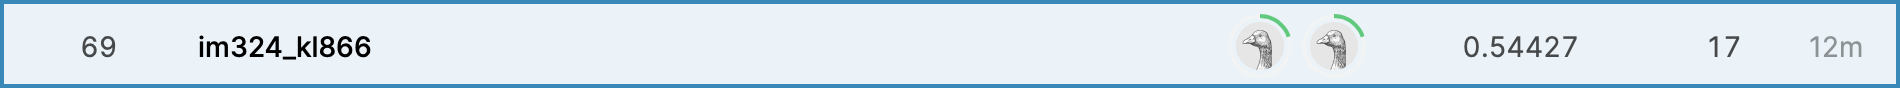

In [10]:
from IPython.display import Image 

path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "p2_pic.png")
Image(filename=path)

#Appendix
---

### Tentative grading guideline

- (5 pts) Dataset exploration.
- (20 pts) Design and implementation of the HMM model. Specifically, calculations of emission/transition probability, smoothing, handling of unknown words.
- (20 pts) Design and implementation of the MEMM, as well as the feature set and how the feature extraction is done.
- (20 pts) Experiment design and methodology. Investigations into feature sets and unknown word handling/smoothing.
- (20 pts) Error analysis and comparison of **HMM** model with the **MEMM**. 
- (10 pts) Report: organization, clarity and including the **corresponding pieces of code for the implementations**.
- (5 pts) **Submission to Kaggle**. In the report, you should add a screenshot of your team’s performance on kaggle leaderboard.



In [ ]:
## Create PDF

In [66]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [67]:
%%capture
# the red text is a placeholder! Change it to your directory structure!
!cp 'drive/My Drive/Colab Notebooks/4740_FA20_p2_im324_kl866.ipynb' ./ 

In [68]:
# the red text is a placeholder! Change it to the name of this notebook!
!jupyter nbconvert --to pdf "4740_FA20_p2_im324_kl866.ipynb"

[NbConvertApp] Converting notebook 4740_FA20_p2_im324_kl866.ipynb to pdf
[NbConvertApp] Support files will be in 4740_FA20_p2_im324_kl866_files/
[NbConvertApp] Making directory ./4740_FA20_p2_im324_kl866_files
[NbConvertApp] Making directory ./4740_FA20_p2_im324_kl866_files
[NbConvertApp] Making directory ./4740_FA20_p2_im324_kl866_files
[NbConvertApp] Writing 167825 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 223481 bytes to 4740_FA20_p2_im324_kl866.pdf
